# Recognising NRs


In [1]:
import sys
import os
basef = "/mnt/data/Anastasia/"
wdirs = ["/mnt/data/Anastasia/18_11_29_pd23_11_div6_25Hzsqwave/",
         basef+"18_12_10_pd3_12_div7_WIS_NR-BeRST",
         basef+"18_12_12_pd7_12_div5_WIS_NR-BeRST",
         basef+"18_12_12_pd7_12_div5_WIS_NR-BeRST_DM590",
         basef+"19_01_30_pd25_01_div5_NR_BeRST",
         basef+"19_02_05_pd1_02_div4_NR_BeRST"
]

dfiles = []
for dirt in wdirs:
    basedir = dirt
    files = os.listdir(basedir)
    if dirt[-1] != '/':
        dirt = dirt+'/'
    for f in files:
        if f[-4:]=='.tif': 
            try:
                i = int(f[-5])
                dfiles.append(dirt+f)
            except:
                pass

            
     
               
  
            
#dfiles = dfiles[4:8]

print(len(dfiles))
print(dfiles)


35
['/mnt/data/Anastasia/18_11_29_pd23_11_div6_25Hzsqwave/cell2_3.tif', '/mnt/data/Anastasia/18_11_29_pd23_11_div6_25Hzsqwave/cell1_1.tif', '/mnt/data/Anastasia/18_11_29_pd23_11_div6_25Hzsqwave/cell3_5.tif', '/mnt/data/Anastasia/18_11_29_pd23_11_div6_25Hzsqwave/cell4_7.tif', '/mnt/data/Anastasia/18_12_10_pd3_12_div7_WIS_NR-BeRST/cell5_10.tif', '/mnt/data/Anastasia/18_12_10_pd3_12_div7_WIS_NR-BeRST/cell2_3.tif', '/mnt/data/Anastasia/18_12_10_pd3_12_div7_WIS_NR-BeRST/cell1_1.tif', '/mnt/data/Anastasia/18_12_10_pd3_12_div7_WIS_NR-BeRST/cell4_8.tif', '/mnt/data/Anastasia/18_12_10_pd3_12_div7_WIS_NR-BeRST/cell7_14.tif', '/mnt/data/Anastasia/18_12_10_pd3_12_div7_WIS_NR-BeRST/cell6_12.tif', '/mnt/data/Anastasia/18_12_10_pd3_12_div7_WIS_NR-BeRST/cell3_5.tif', '/mnt/data/Anastasia/18_12_12_pd7_12_div5_WIS_NR-BeRST/cell1_1.tif', '/mnt/data/Anastasia/18_12_12_pd7_12_div5_WIS_NR-BeRST/cell3_7.tif', '/mnt/data/Anastasia/18_12_12_pd7_12_div5_WIS_NR-BeRST/cell2_4.tif', '/mnt/data/Anastasia/18_12_12_p

In [2]:
sys.path.append("/export/home1/users/bssn/serna/GitIBENS/Nanorods")

In [3]:
from numpy import *
from matplotlib.pylab import *
import scipy.optimize as opt
import pickle
from scipy.optimize import minimize,least_squares
from scipy.stats import linregress

%matplotlib inline

In [4]:
from signal_analysis.core import dblgausfit,dblgaussd

In [5]:
def bimod(x):
    m1 = mean(x)
    m2 = std(x)
    m3 = mean((x-m1)**3)/m2**3
    m4 = mean((x-m1)**4)/m2**4
    return((m3**2+1)/m4)

In [6]:
import seaborn as sns
sns.set(style="white", color_codes=True)

In [7]:
#with open('/mnt/data/Anastasia/RecognisingNRs_allcells.pkl','rb') as f:
#    imsk,nwdirs,dfilesF,dgps,ampst,idx0,xds,xde,xden,Des,Dep = pickle.load(f)

with open('/mnt/data/Anastasia/full_stats.pkl','rb') as f:
    imsk,nwdirs,dgps,ampst,idx0,xds,xde,xden,Des,Dep = pickle.load(f)


(86801,)


Text(0,0.5,'p_1')

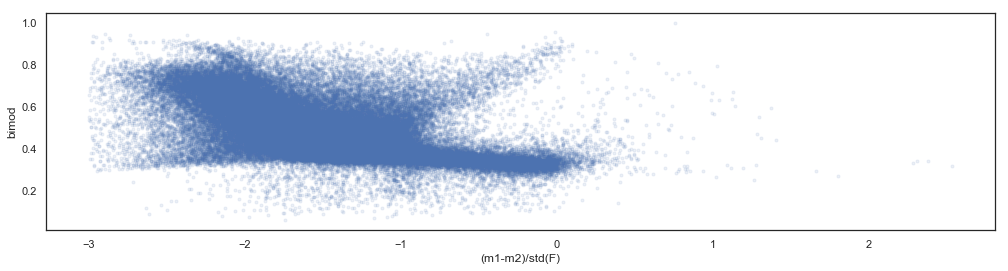

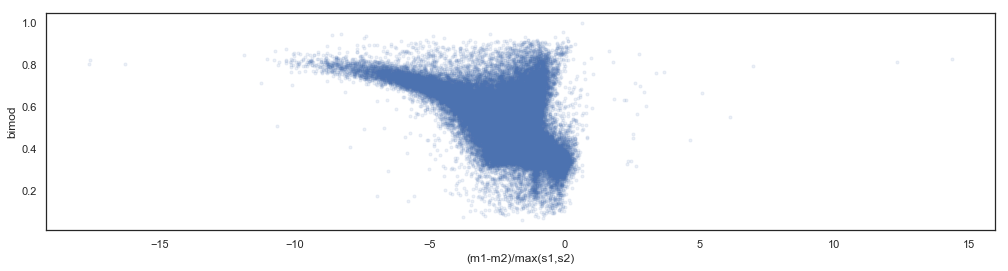

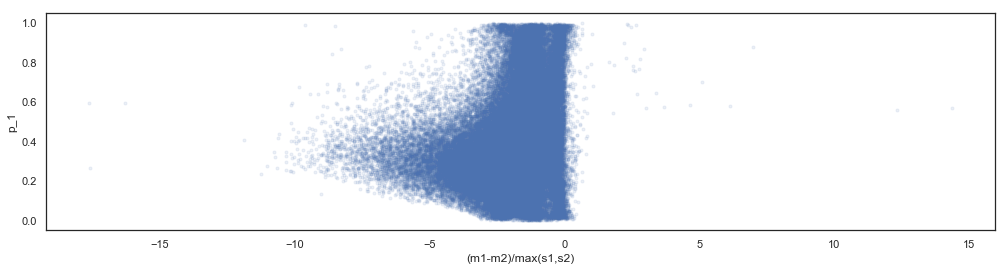

In [8]:
sel = (abs(dgps[:,3]-dgps[:,5])<3)*(dgps[:,2]>0)*(dgps[:,2]<1)
figure(figsize=(17,4))
plot(dgps[sel,3]-dgps[sel,5],ampst[sel,2],'.',alpha=0.1)
xlabel("(m1-m2)/std(F)")
ylabel("bimod")
figure(figsize=(17,4))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
#s1 = column_stack((dgps[sel,6],dgps[sel,4])).sum(axis=1)

xt = (dgps[:,3]-dgps[:,5])/s1
sel = (abs(dgps[:,3]-dgps[:,5])<3)*(dgps[:,2]>0)*(dgps[:,2]<1)*(abs(xt)<20)
print(s1.shape)
plot(xt[sel],ampst[sel,2],'.',alpha=0.1)
xlabel("(m1-m2)/max(s1,s2)")
ylabel("bimod")
figure(figsize=(17,4))
plot(xt[sel],dgps[sel,2],'.',alpha=0.1)
xlabel("(m1-m2)/max(s1,s2)")
ylabel("p_1")

In [9]:
def conditionnumber(a,D,dG = None):
    if dG is not None:
        if dG >4:
            return(7)
    if a<0.1:
        return(0)
    if a>0.1 and a<0.4:
        return(1)
    if a>0.4 and a<1.0 and D<1e-2:
        return(2)
    if a>1.0 and a<3.0 and D>1e-2:
        return(3)
    if a>1.0 and a<3.0 and D<1e-2:
        return(4)
    if a>3.0:
        return(5)
    return(6)


def conditionlabel(i):
    if i==0:
        return("Amp/Bg<0.1")
    if i==1:
        return("0.1< Amp/Bg <0.4")
    if i==2:
        return("0.4< Amp/Bg <1.0 & D0<0.01 um2/s")
    if i==3:
        return("1< Amp/Bg <3 & D0>0.01 um2/s")
    if i==4:
        return("1< Amp/Bg <3 & D0<0.01 um2/s")
    if i==5:
        return("Amp/Bg>3")
    if i==6:
        return("Others")
    if i==7:
        return("Sharp Nanorod")


#sel = (ampst[:,0]/ampst[:,1]>0.1)*(ampst[:,0]/ampst[:,1]<0.4)
#sel = (ampst[:,0]/ampst[:,1]>0.4)*(ampst[:,0]/ampst[:,1]<1.0)*(Des[:,0]<1e-2)
#sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]>1e-2)
#sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]<1e-2)
#sel0 = (ampst[:,0]/ampst[:,1]>3.0)
#conditionnumber(0.5,0.6)

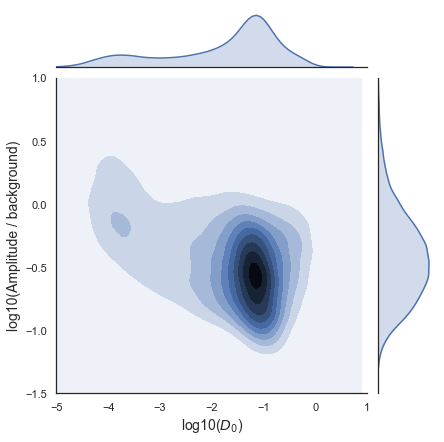

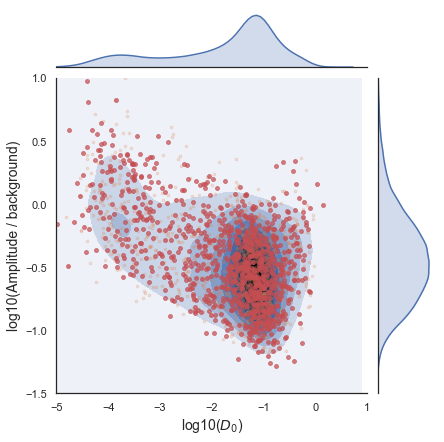

In [10]:
yt = ampst[:,0]/ampst[:,1]
xt = Des[:,0]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
#g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2

selv = permutation(arange(len(xt)))[:1000]
g.x = xt[selv]
g.y = yt[selv]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

xt = xt[imsk[idx0[sel]] ==1]
yt = yt[imsk[idx0[sel]] ==1]
selv = permutation(arange(len(xt)))[:1000]
g.x = xt[selv]
g.y = yt[selv]
g.plot_joint(plt.scatter, marker='.', c='C3', s=60,alpha=0.7)


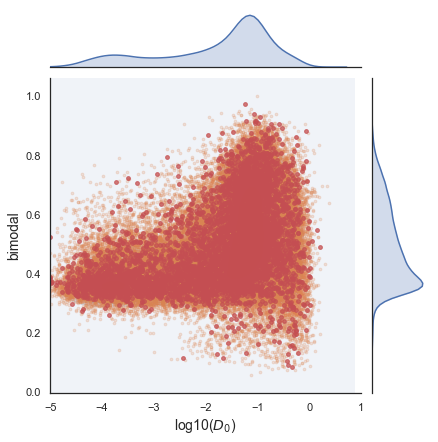

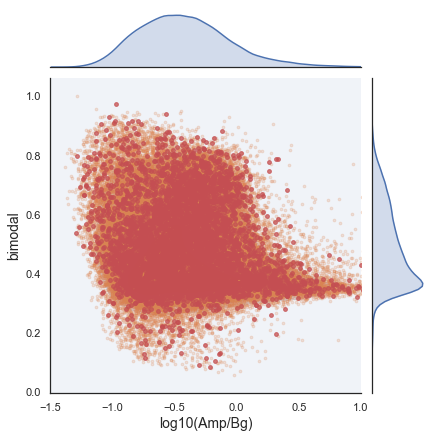

In [11]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

#g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

g.x =  xt[imsk[idx0[sel]] ==1]
g.y = yt[imsk[idx0[sel]] ==1]
g.plot_joint(plt.scatter, marker='.', c='C3', s=60,alpha=0.7)

yt = ampst[:,2]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-1.5,1.0])
#g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10(Amp/Bg)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)
#g.x = df2.x2
#g.y = df2.y2
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

g.x =  xt[imsk[idx0[sel]] ==1]
g.y = yt[imsk[idx0[sel]] ==1]
g.plot_joint(plt.scatter, marker='.', c='C3', s=60,alpha=0.7)


<Figure size 432x288 with 0 Axes>

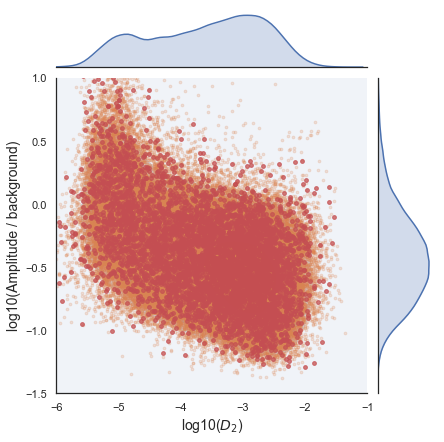

In [12]:
yt = ampst[:,0]/ampst[:,1]
xt = Dep[:,3]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
fig = figure()
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-6,-1])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

g.x =  xt[imsk[idx0[sel]] ==1]
g.y = yt[imsk[idx0[sel]] ==1]
g.plot_joint(plt.scatter, marker='.', c='C3', s=60,alpha=0.7)


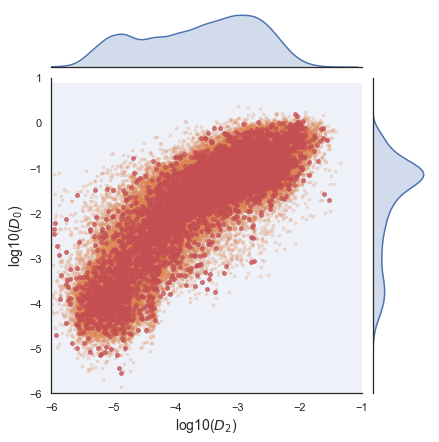

In [13]:
yt = Des[:,0]
xt = Dep[:,3]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = log10(yt[sel])
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-6,1.0])
g.ax_joint.set_xlim([-6,-1])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("log10($D_0$)",fontsize=14)
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

g.x =  xt[imsk[idx0[sel]] ==1]
g.y = yt[imsk[idx0[sel]] ==1]
g.plot_joint(plt.scatter, marker='.', c='C3', s=60,alpha=0.7)


In [15]:
dfilesF = []
driftcorrected = True
for i,dirt in enumerate(nwdirs):
    basedir = dirt
    files = os.listdir(basedir)
    dfiles = []
    if driftcorrected:
        for f in files:
            if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]=='DC': dfiles.append(basedir+f)
    else:
        for f in files:
            if f[-4:]=='.npy'and f[:4]=='posh' and f[-6:-4]!='DC': dfiles.append(basedir+f)
    dfiles.sort()
    dfilesF.extend(dfiles)
dfiles = dfilesF

In [16]:
yt = 1.0*ampst[:,0]/ampst[:,1]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = log10(yt[sel])


NRs selected:  [44657  5524 65184]


Text(0.5,0,'t')

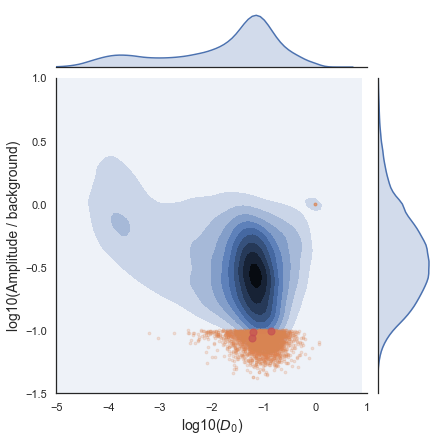

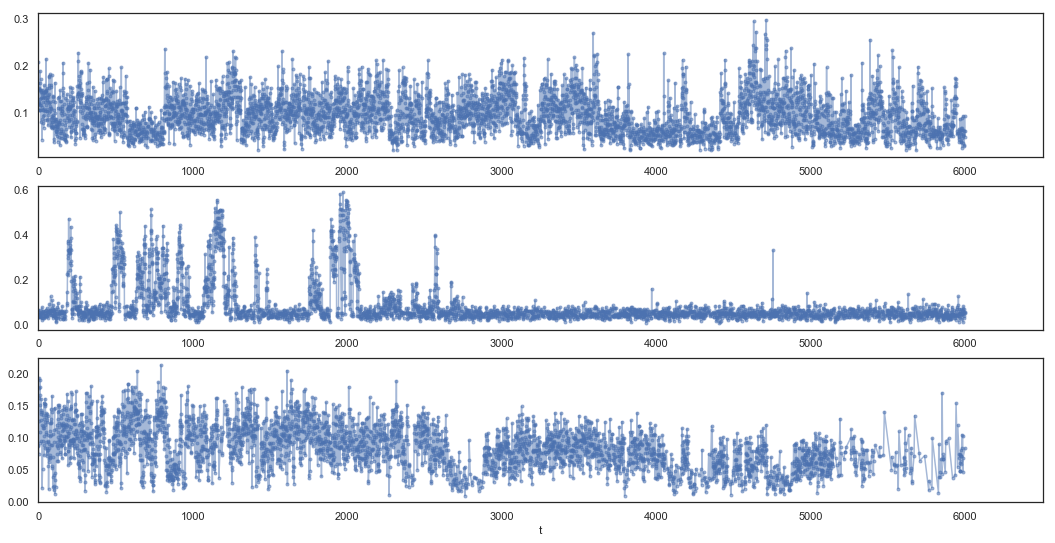

In [17]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = ampst[:,0]/ampst[:,1]<0.1

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)


it = permutation(arange(ampst.shape[0])[sel])[:3]
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

print('NRs selected: ' ,it)

#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
#fig.title("Amplitude/Background < 0.1")
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [18]:
sel = ampst[:,0]/ampst[:,1]<0.1
it = permutation(arange(len(xt))[sel])[:3]
print(it,idx0[it])

[73025 72087 77215] [73135 72190 77333]


NRs selected:  [35129 37299 30763]


Text(0.5,0,'t')

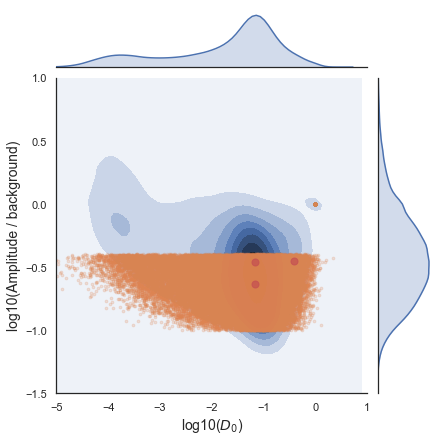

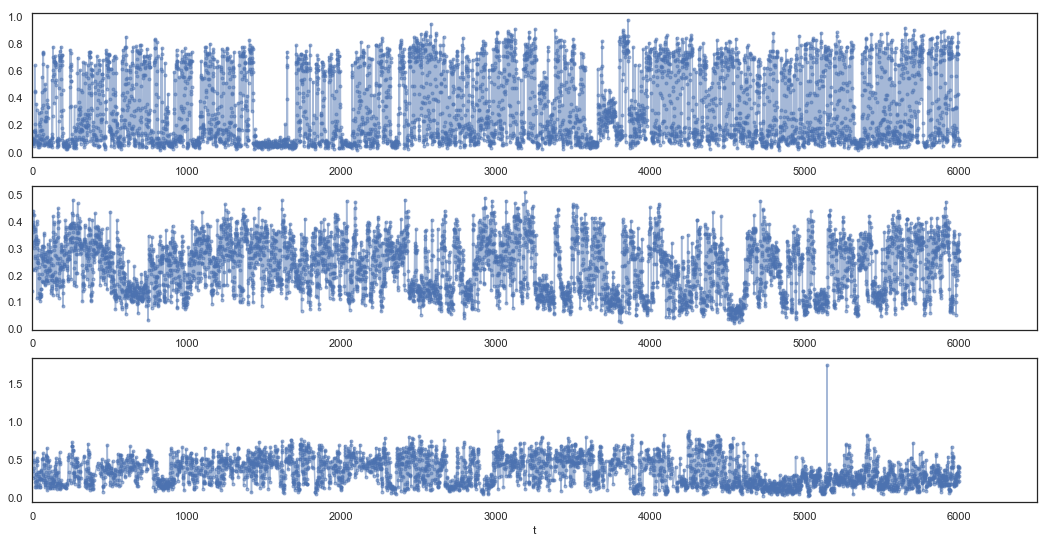

In [19]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>0.1)*(ampst[:,0]/ampst[:,1]<0.4)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

print('NRs selected: ' ,it)
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [58610 47926 47958]


Text(0.5,0,'t')

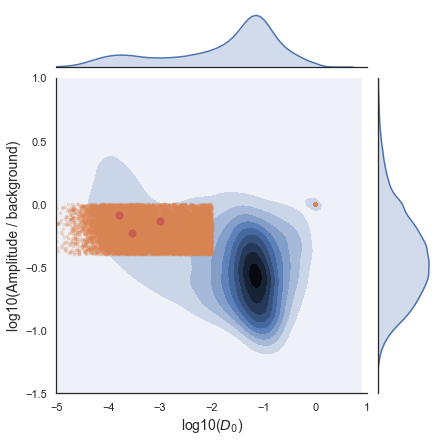

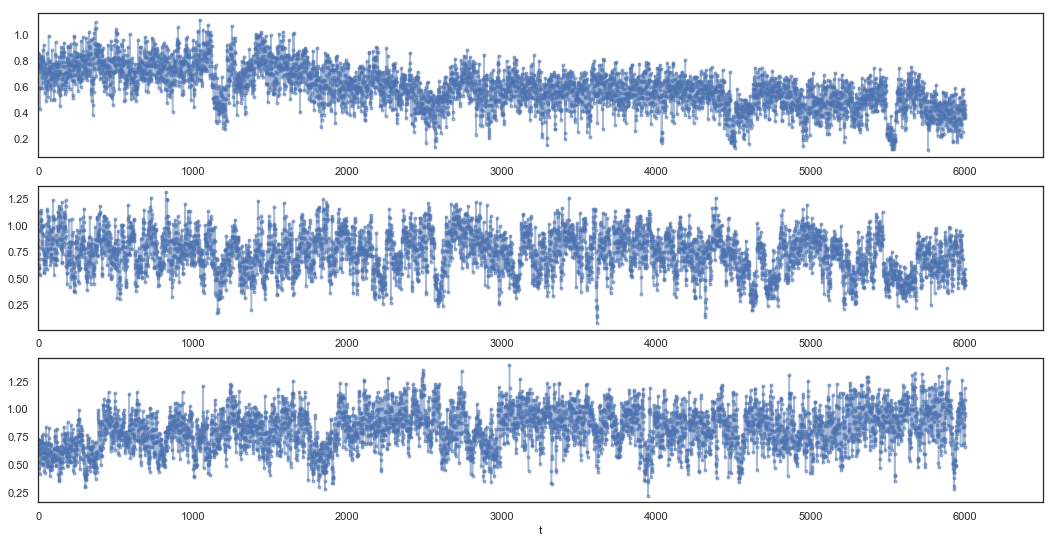

In [20]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>0.4)*(ampst[:,0]/ampst[:,1]<1.0)*(Des[:,0]<1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)
it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)

fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [47893 81841 16288]


Text(0.5,0,'t')

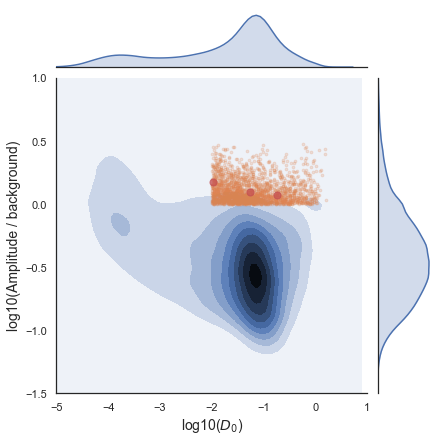

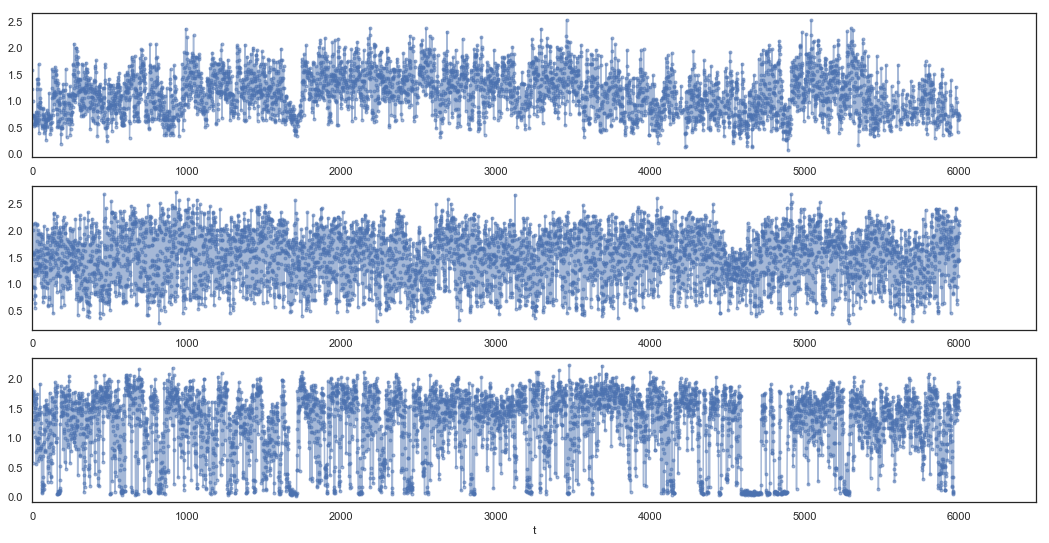

In [21]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]>1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)
it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [47780 53833 24337]


Text(0.5,0,'t')

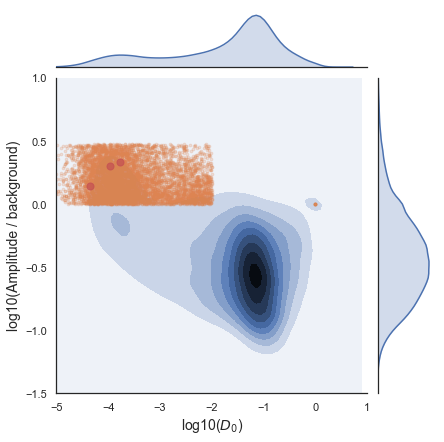

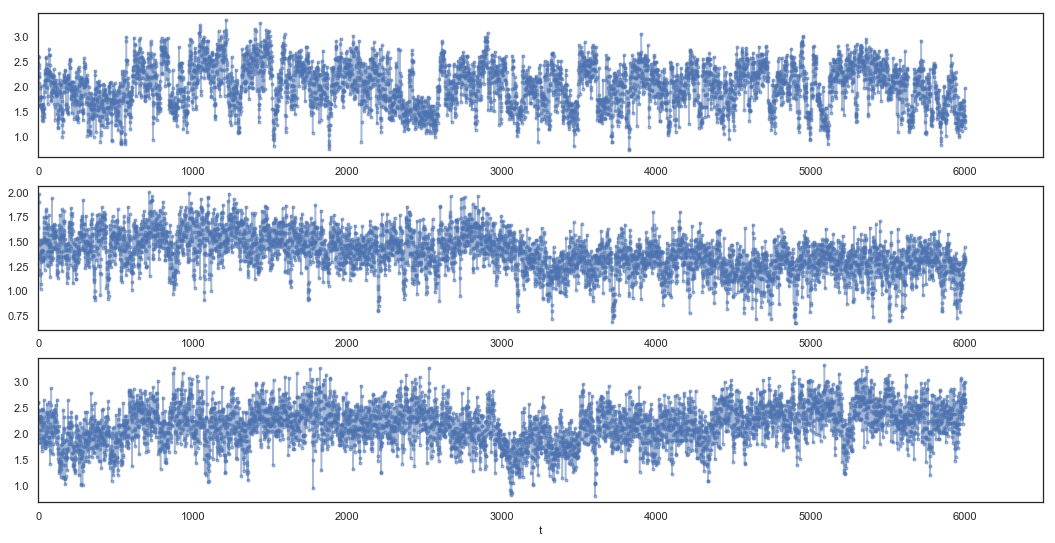

In [22]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>1.0)*(ampst[:,0]/ampst[:,1]<3.0)*(Des[:,0]<1e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
#fig = figure(figsize=(14,8))
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
print('NRs selected: ' ,it)
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [23]:
print(log10(ampst[254,0]/ampst[254,1]),log10(Des[254,0]))

-0.43091703270050397 -1.247095545391234


NRs selected:  [20044 38970 47758]


Text(0.5,0,'t')

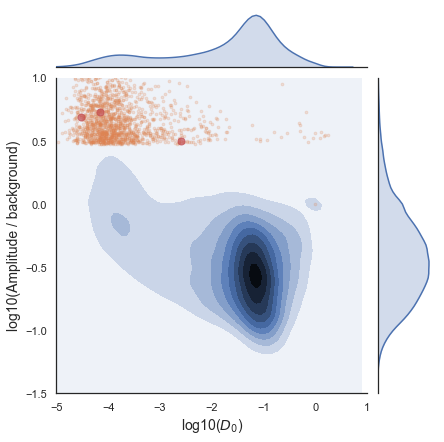

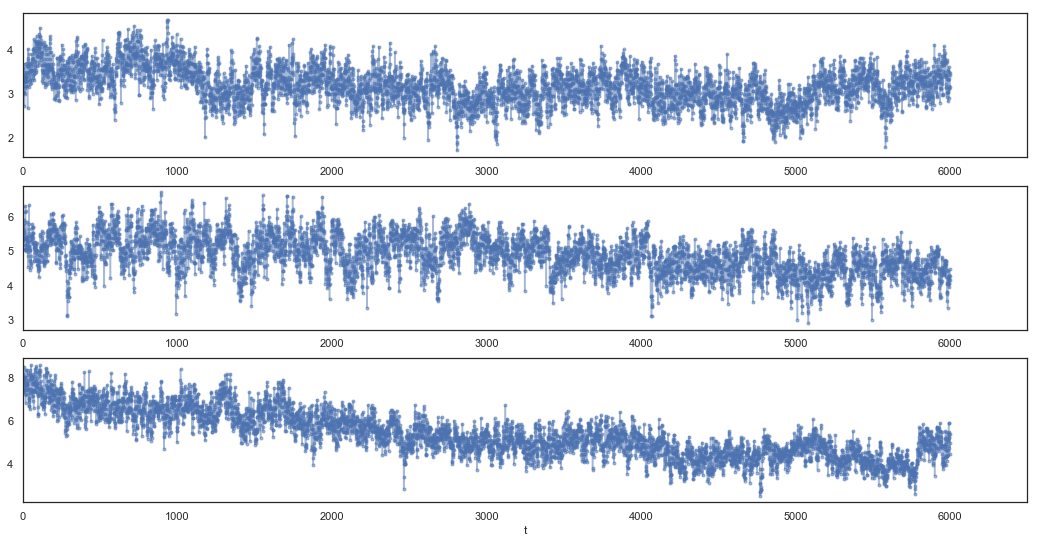

In [24]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_ylim([-1.5,1.0])
g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("log10(Amplitude / background)",fontsize=14)

sel = (ampst[:,0]/ampst[:,1]>3.0)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [25]:
yt = 1.0*ampst[:,2]
xt = ampst[:,0]/ampst[:,1]
sel = (xt>0)*(yt>0)
xt = log10(xt[sel])
yt = yt[sel] #log10(yt[sel])

NRs selected:  [37536 16684 60792]


Text(0.5,0,'t')

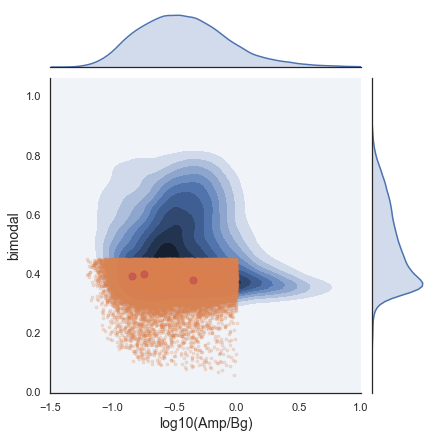

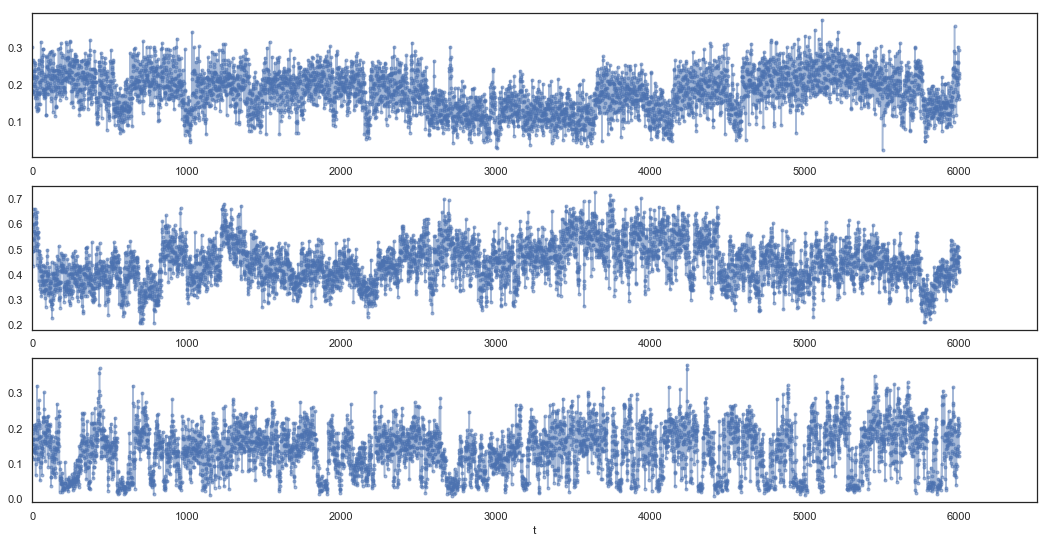

In [26]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-1.5,1.0])
g.ax_joint.set_xlabel("log10(Amp/Bg)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]<0.45)*(ampst[:,0]/ampst[:,1]<1.0)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [27]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])

In [28]:
%matplotlib inline

NRs selected:  [75619 62451 18385]


Text(0.5,0,'t')

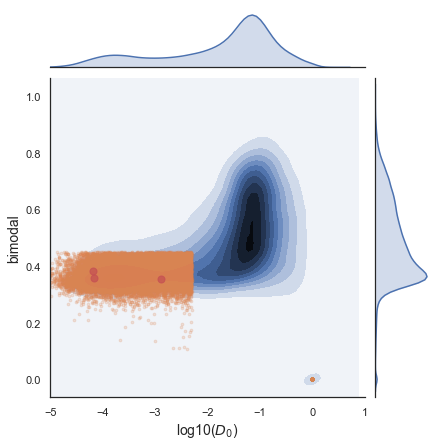

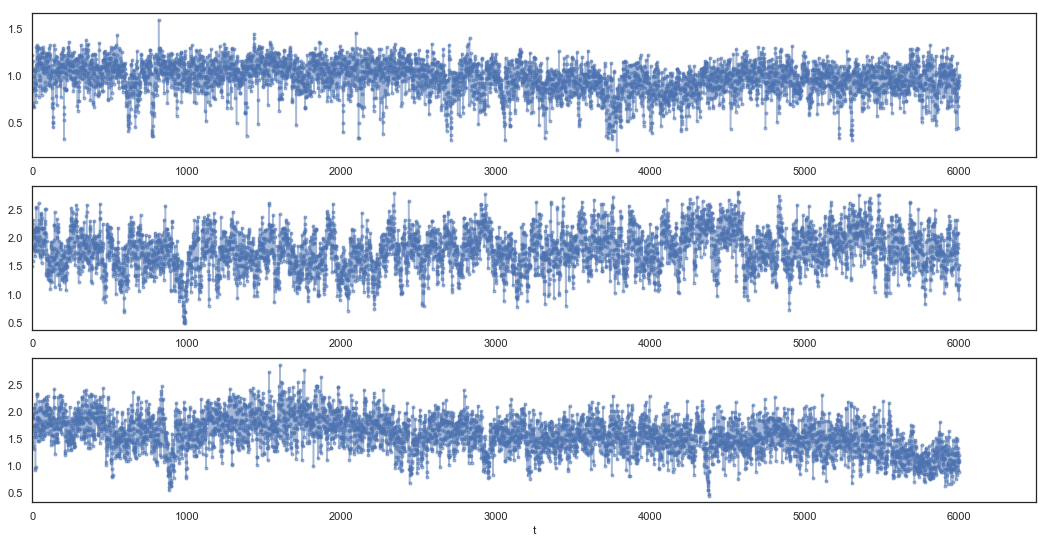

In [29]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]<0.45)*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [30]:
yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(yt>0)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])

In [31]:
%matplotlib inline

NRs selected:  [60053 71781 14446]


Text(0.5,0,'t')

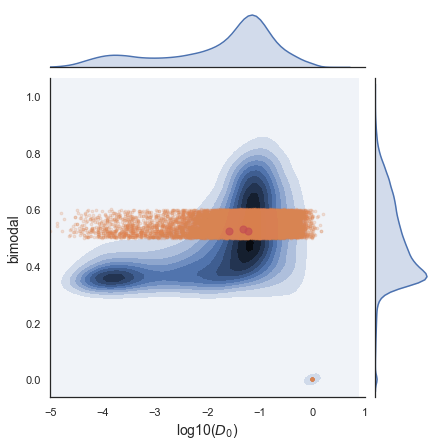

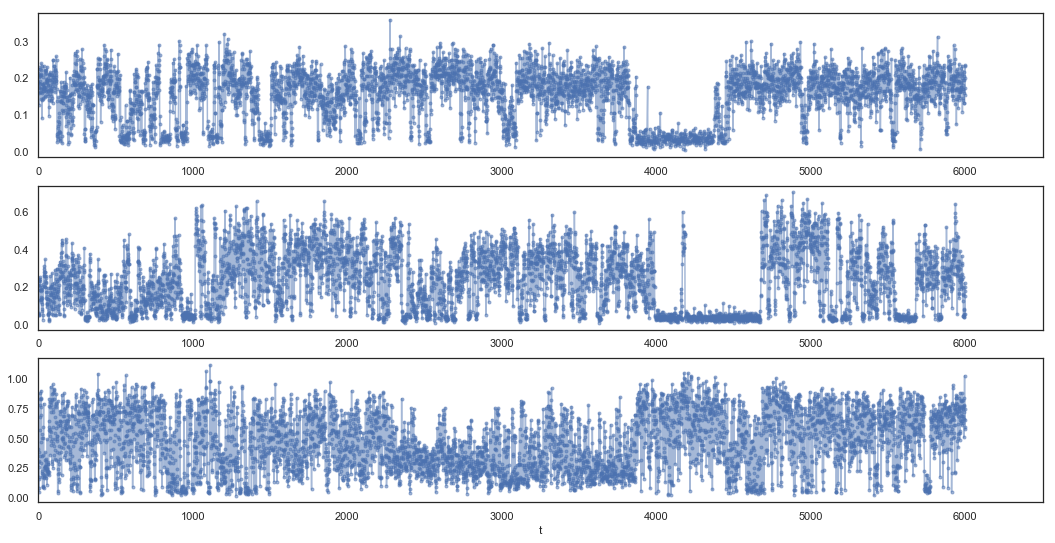

In [32]:
g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("bimodal",fontsize=14)

sel = (ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

In [33]:
%matplotlib inline

-1.2049783952870343
NRs selected:  [23029 32911 43538]


Text(0.5,0,'t')

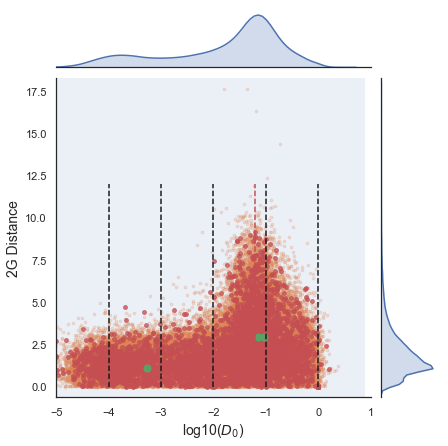

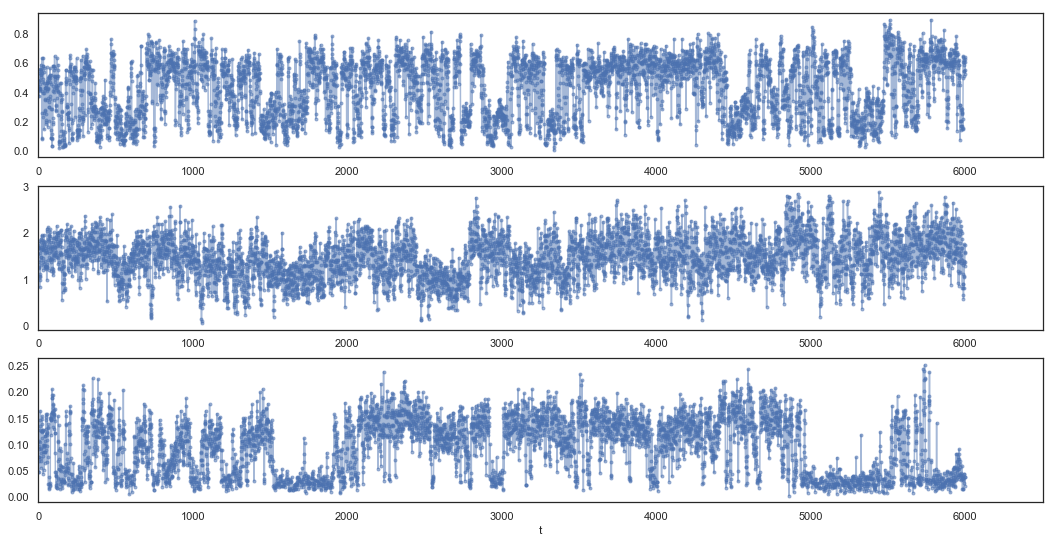

In [43]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = isfinite(ampst[:,2])#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

g.x =  xt[imsk[idx0[sel]] ==1]
g.y = yt[imsk[idx0[sel]] ==1]
g.plot_joint(plt.scatter, marker='.', c='C3', s=60,alpha=0.7)
plot([0,0],[0,12],'k--')
plot([-1,-1],[0,12],'k--')
plot([-2,-2],[0,12],'k--')
plot([-3,-3],[0,12],'k--')
plot([-4,-4],[0,12],'k--')
plot([-5,-5],[0,12],'k--')
xtb = xt[imsk[idx0[sel]] ==1]
ytb = yt[imsk[idx0[sel]] ==1]
newsel = ytb>3.0
plot([mean(xtb[newsel]),mean(xtb[newsel])],[0,12],'r--')
print(mean(xtb[newsel]))

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C2', s=50,alpha=0.9)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [40557 29843 86597]


Text(0.5,0,'t')

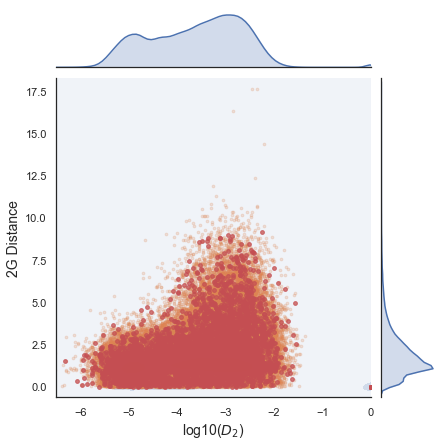

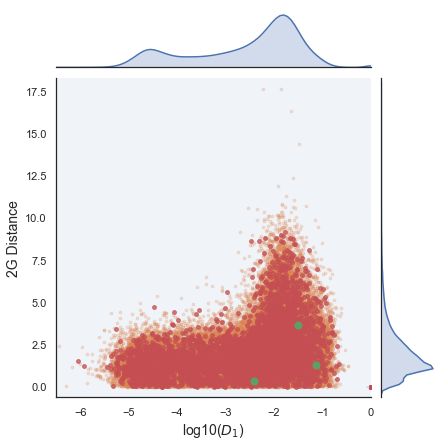

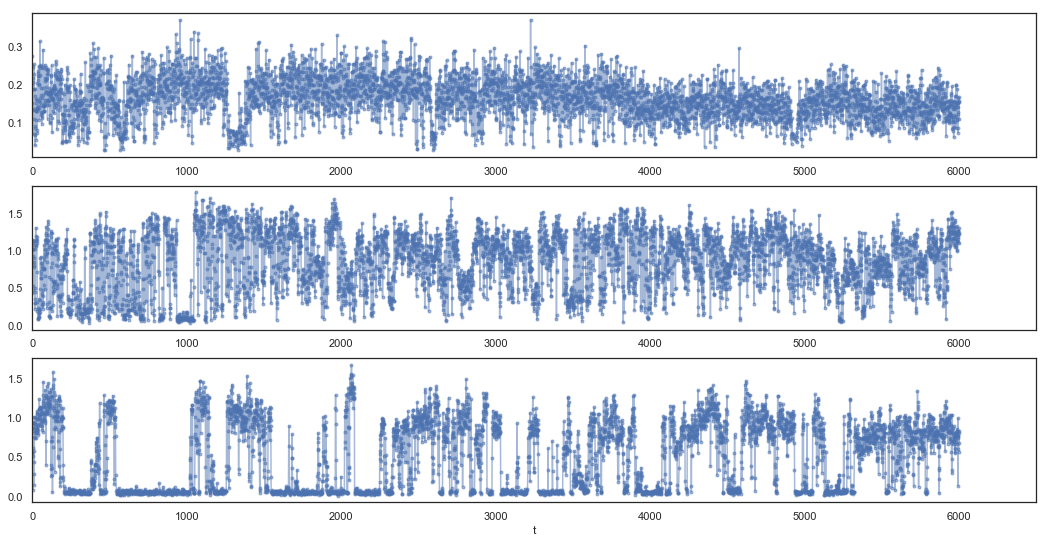

In [35]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Dep[:,3]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-6.5,0])
g.ax_joint.set_xlabel("log10($D_2$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = isfinite(ampst[:,2])#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

g.x =  xt[imsk[idx0[sel]] ==1]
g.y = yt[imsk[idx0[sel]] ==1]
g.plot_joint(plt.scatter, marker='.', c='C3', s=60,alpha=0.7)

s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Dep[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-6.5,0])
g.ax_joint.set_xlabel("log10($D_1$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = isfinite(ampst[:,2])#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

g.x =  xt[imsk[idx0[sel]] ==1]
g.y = yt[imsk[idx0[sel]] ==1]
g.plot_joint(plt.scatter, marker='.', c='C3', s=60,alpha=0.7)


it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C2', s=50,alpha=0.9)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [7060 5355 4942]


Text(0.5,0,'t')

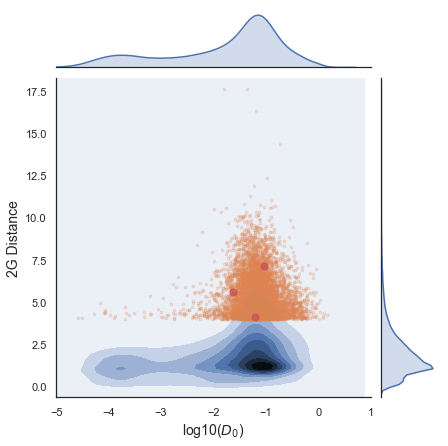

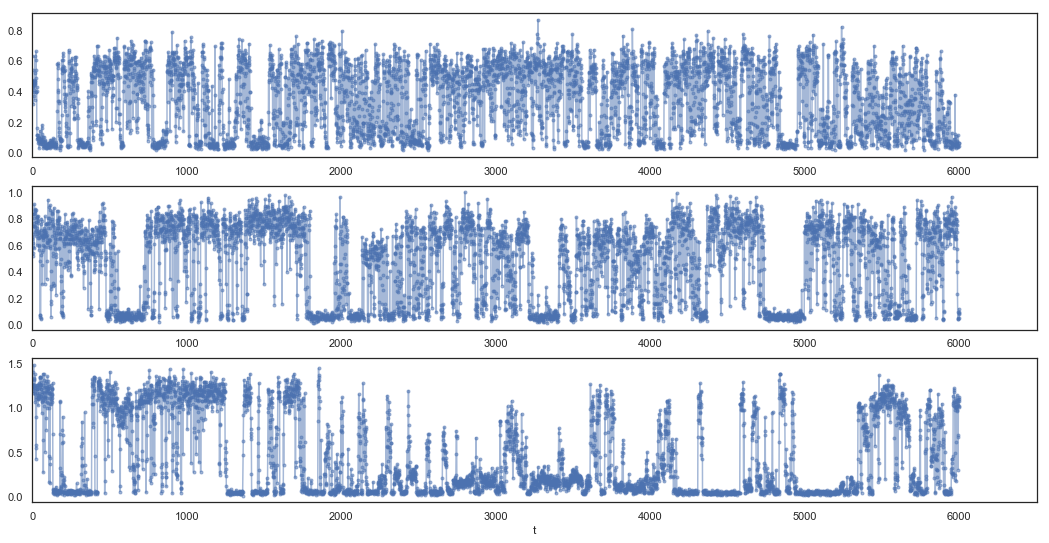

In [36]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = yt>4#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [35519 28791 29035]


Text(0.5,0,'t')

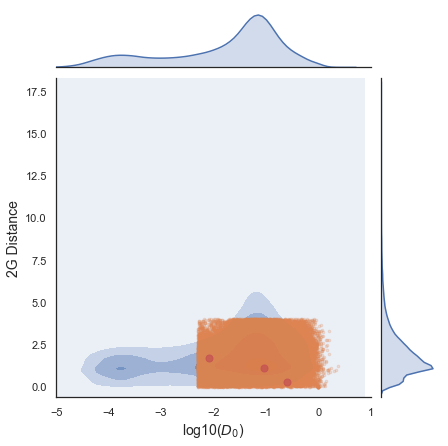

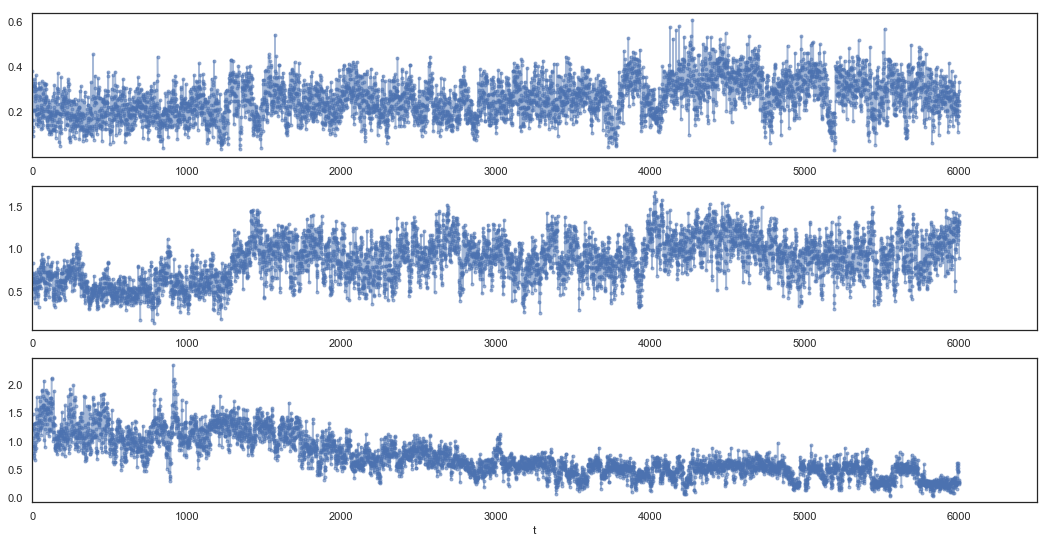

In [37]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = (yt<4)*(Des[:,0]>.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [73107 50849 57341]


Text(0.5,0,'t')

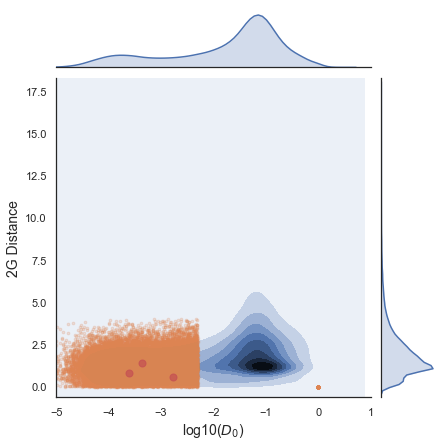

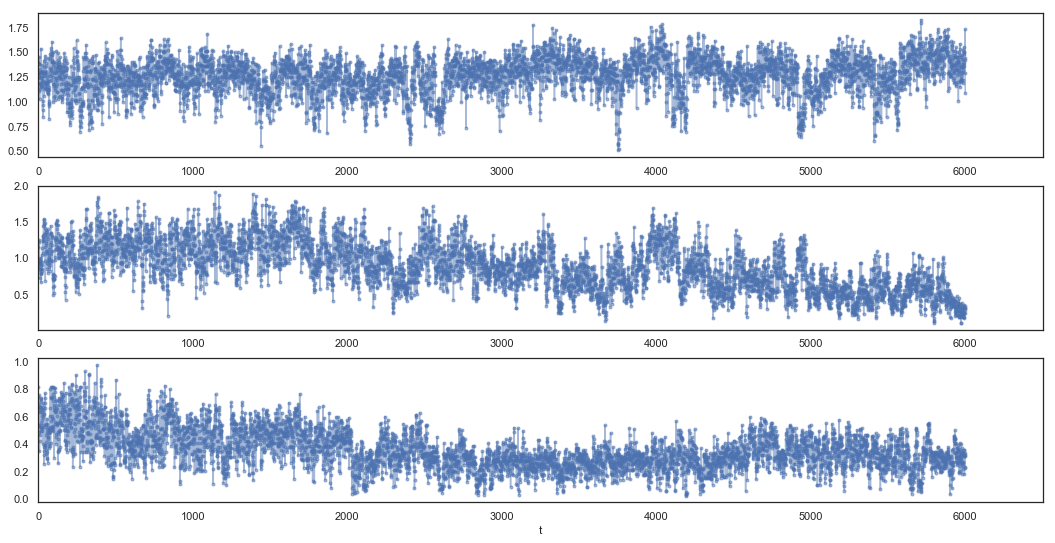

In [38]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = (yt<4)*(Des[:,0]<.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

NRs selected:  [62116 49838 72399]


Text(0.5,0,'t')

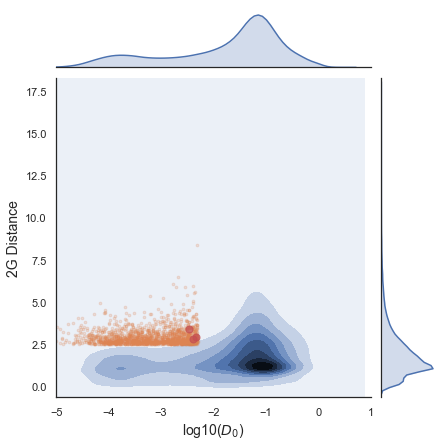

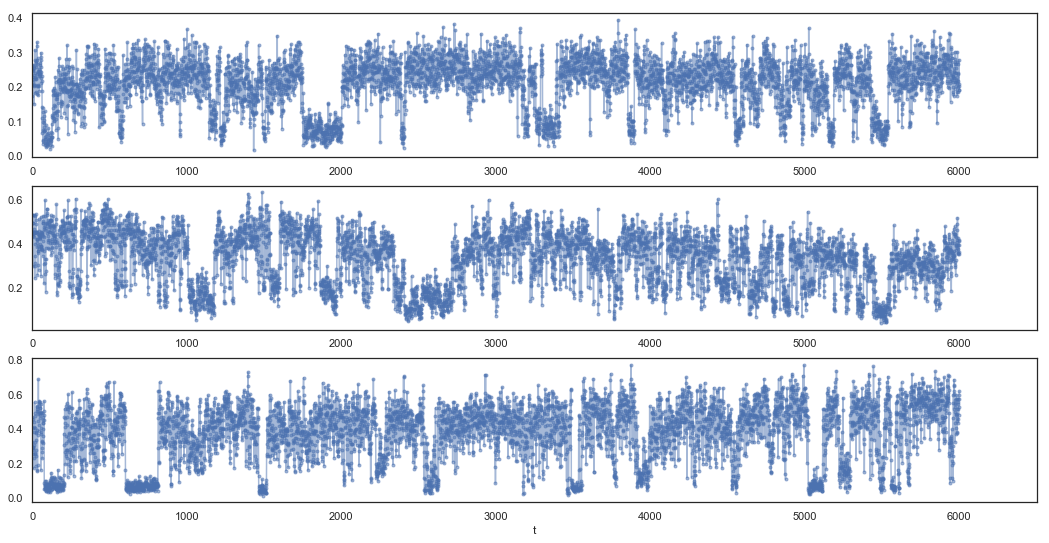

In [39]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])


g = sns.jointplot(x=xt, y=yt, kind='kde')

g.ax_joint.set_xlim([-5,1])
g.ax_joint.set_xlabel("log10($D_0$)",fontsize=14)
g.ax_joint.set_ylabel("2G Distance",fontsize=14)

sel = (yt>2.5)*(Des[:,0]<.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

g.x = xt[sel]
g.y = yt[sel]
g.plot_joint(plt.scatter, marker='.', c='C1', s=30,alpha=0.2)

it = permutation(arange(ampst.shape[0])[sel])[:3]
print('NRs selected: ' ,it)
g.x = xt[it]
g.y = yt[it]
g.plot_joint(plt.scatter, marker='o', c='C3', s=50,alpha=0.7)#fig = figure(figsize=(14,8))
#fig = figure(figsize=(14,8))
fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

ax[-1].set_xlabel("t")

[3.12330566 3.16679271 3.06427178] 510


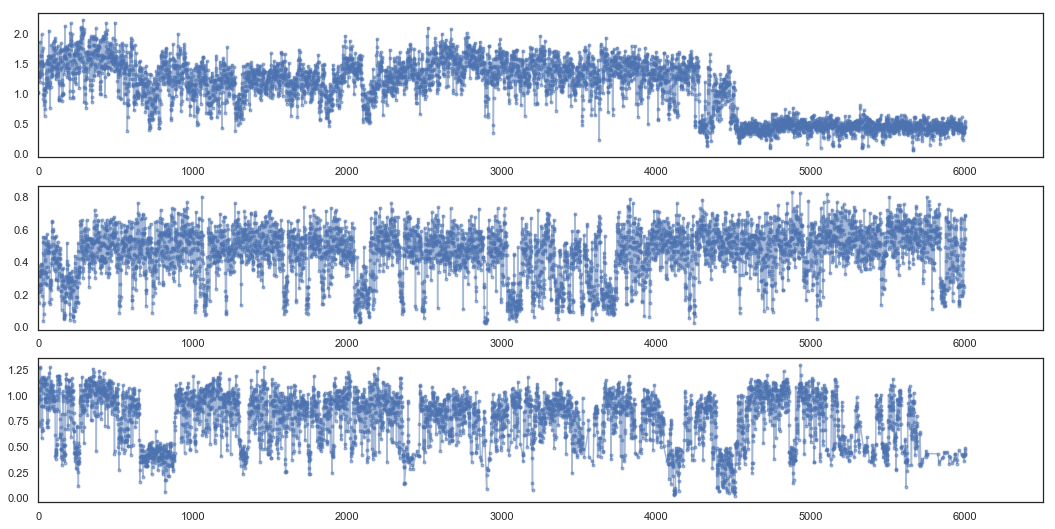

In [40]:
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
#yt = 1.0*ampst[:,2]
xt = 1.0*Des[:,0]
sel = (xt>0)*(abs(yt)<20)
xt[~sel] = 0
yt[~sel] = 0
xt[sel] = log10(xt[sel])
yt[sel] = yt[sel] #log10(yt[sel])

sel = (yt>3.0)*(Des[:,0]<.50e-2)#(ampst[:,2]>0.5)*(ampst[:,2]<0.6)#*(Des[:,0]<.50e-2)

it = permutation(arange(ampst.shape[0])[sel])[:3]

print(yt[it],sel.sum())

fig, ax = subplots(nrows=3,figsize=(18,9))
for j,i in enumerate(idx0[it]):
    name = dfiles[i]; popts = load(name); t = arange(popts.shape[0]); posx = popts[:,5]; posy = popts[:,6]; amp = popts[:,0]
    th = 0; th2 = 13.0; sel = (popts[:,-1]==0)*(posx>0.1)*(posy>0.1)*(posx<4.9)*(posy<4.9)*(amp>exp(th))*(amp<exp(th2))
    ax[j].plot(t[sel],popts[sel,0]/popts[sel,4],'.-',alpha=0.5,label=i)
    ax[j].set_xlim(0,6500)

In [41]:
#sel = (abs(dgps[:,3]-dgps[:,5])<3))
s1 = column_stack((dgps[:,6],dgps[:,4])).max(axis=1)
yt = abs((dgps[:,3]-dgps[:,5])/s1)
zt = 1.0*ampst[:,2]
at = ampst[:,0]/ampst[:,1]
at2 = (dgps[:,0]+dgps[:,1]*column_stack((dgps[:,3],dgps[:,5])).max(axis=1))/ampst[:,1]
xt = 1.0*Des[:,0]
xt2 = Dep[:,0]
xt3 = Dep[:,3]
sel = (xt>0)*(xt2>0)*(xt3>0)*(zt>0)*(abs(yt)<20)
xt = log10(xt[sel])
xt2 = log10(xt2[sel])
xt3 = log10(xt3[sel])
yt = yt[sel] #log10(yt[sel])
zt = zt[sel]
at = log10(at[sel])
at2 = log10(at2[sel])
#  (m1-m2)/max(s1,s2), bimod, A/bg, A_on/bg, D0, D1, D2
data = column_stack((yt,zt,at,at2,xt,xt2,xt3))
savetxt('stats_temp.dat',data,header='#  (m1-m2)/max(s1,s2), bimod, A/bg, A_on/bg, D0, D1, D2')

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
